## 1. Imports

**Pykrx 패키지를 활용해 코스피의 주식 데이터를 수집**  
코스피의 구성종목 중 2013-04-01~ 2023-04-31에 PER, PBR, DIV에 결측치가 존재하지 않는 주식에 대해 데이터를 수집  
총 186개의 종목에 대해 데이터를 수집
이후의 결과 비교를 위해 해당 종목의 수익률의 평균을 벤치마크로 삼기로 함

In [1]:
import FinanceDataReader as fdr
import pickle

import mybacktest as backtest # 자체 제작한 모듈

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('data/krx_dict.pkl', 'rb') as f:
    kospi_dict = pickle.load(f)

In [3]:
tickers = kospi_dict['per'].columns.tolist()
len(tickers)

186

In [4]:
kospi_price = kospi_dict['price'][tickers]
kospi_cap = kospi_dict['cap'][tickers]
kospi_per = kospi_dict['per']
kospi_pbr = kospi_dict['pbr']

In [5]:
for df in [kospi_price, kospi_cap, kospi_per, kospi_pbr]:
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [6]:
benchmark_return = kospi_price.pct_change().dropna().mean(axis=1)
benchmark_return

날짜
2013-04-02    0.001896
2013-04-03    0.003145
2013-04-04   -0.003133
2013-04-05   -0.009468
2013-04-08   -0.014628
                ...   
2023-03-27   -0.000318
2023-03-28    0.010125
2023-03-29    0.006841
2023-03-30    0.002581
2023-03-31    0.004119
Length: 2461, dtype: float64

## 2. 전략 수립 및 검증

### 2-1 개요

##### **Value 팩터는 성장주가 가치주에 비해 Outperorm함을 의미**    
PBR이 낮은 주식(가치주)을 매도,높은 주식(가치주)을 매수하는 방식으로 포트폴리오를 설계,그 결과를 검증   
먼저 PBR을 기준으로 Test해보기로 함(추후에 PER을 기준으로도 Test)    
우선, 2013-04-01~ 2020-04-01까지의 기간을 대상으로 전략을 수립, 그 결과를 검증  
###### **만약, 결과가 안 좋을 시 다른 방식으로 전략을 수정**  

**cf) 백테스트 방식**  
각 날짜별로 보유 비중을 정하고, 해당 기간동안 각 자산을 전체자산 대비 정해진 비중만큼 매수 또는 매도.  
즉, 각 자산을(전체자산(현금+보유주식)* 비중) 매수 또는 매도(소수점 이하 버림).이 때, 현금에 대해서는  
매일 이자가 붙고, 매수/매도 시에는 수수료(commission)을, 매도시에는 세금(tax)를 추가로 납부.  
자세한 내용은 mybacktest 코드 참조  

In [7]:
start, end = "2013-04-01", "2020-04-01"

In [8]:
price_df = kospi_price[(kospi_price.index >= start) & (kospi_price.index <= end)]
price_df.head()

,005930,051910,005380,000270,005490,035420,003670,012330,105560,055550,...,078000,007590,000850,004450,069730,014440,026940,008420,123700,025530
날짜,,,,,,,,,,,,,,,,,,,,,
2013-04-01,30240.0,267500.0,222000.0,55100.0,325000.0,92287.0,11806.0,306000.0,37350.0,40600.0,...,9400.0,6390.0,45800.0,21100.0,3200.0,3125.0,2115.0,1705.0,9430.0,4830.0
2013-04-02,30500.0,259500.0,219500.0,55300.0,321500.0,90247.0,11834.0,306500.0,37300.0,39950.0,...,9440.0,6370.0,45150.0,21650.0,3190.0,3110.0,2090.0,1720.0,9170.0,4845.0
2013-04-03,30420.0,251000.0,218000.0,55100.0,323000.0,90247.0,11797.0,311000.0,37400.0,39850.0,...,9500.0,6250.0,45250.0,22200.0,3175.0,3060.0,2110.0,1740.0,9630.0,4850.0
2013-04-04,30120.0,245500.0,207000.0,53300.0,321000.0,89933.0,11694.0,301500.0,37000.0,39450.0,...,9480.0,6250.0,45150.0,22200.0,3160.0,3015.0,2100.0,1745.0,9620.0,4875.0
2013-04-05,30100.0,239000.0,198000.0,50800.0,312500.0,89776.0,11561.0,287000.0,36200.0,38800.0,...,9550.0,6330.0,43900.0,21750.0,3120.0,3130.0,2045.0,1735.0,9750.0,4860.0


### 2-2 전략 수립 및 검증(1) - 성장주 (Long Short)

##### **PBR이 낮은 40개 매도 PBR이 높은 40개 매수**       
투자금액은 1,000,000,000원로 설정  
각 매수/매도하는 자산의 비중은 1/40로 정함  
거래비용은 수수료 0.015% (매수, 매도 시 모두 부여), 증권거래세 0.2% (매도 시에만 부여)  
이자율은 연 3%를 1일 단위로 바꾼 것으로 설정($(1+0.03)^{(1/252)}-1 $)  
리밸런싱 주기는 20영업일로 설정(20영업일 마다 비중 재조정)

##### **해당 기간의 누적수익률은 -22.93%로 좋지 않은 수익률을 보임(연간 -3.74%)**   
##### **해당기간의 벤치마크 누적수익률은 24.75%(연간 3.29%)**    
test_factor를 활용해 각 분위별 Long Only Portfolio의 성과를 비교해 본 결과,  
1분위 Long-Only Portfolio가 가장 좋은 수익률을 보였고,샤프비율 MDD 모두에서도 가장 좋은 성과를 보임 

In [9]:
commission = 0.00015
tax = 0.002
interest = (1+0.03) ** (1/252) - 1
money = 1e9

In [10]:
factor_df = kospi_pbr[(kospi_pbr.index >= start) & (kospi_pbr.index <= end)]
factor_df.head()

,005930,051910,005380,000270,005490,035420,003670,012330,105560,055550,...,078000,007590,000850,004450,069730,014440,026940,008420,123700,025530
날짜,,,,,,,,,,,,,,,,,,,,,
2013-04-01,2.64,2.07,1.71,1.65,0.74,8.97,2.27,2.16,0.63,0.88,...,1.02,0.77,0.48,0.46,0.46,0.74,0.42,0.43,1.35,0.64
2013-04-02,2.66,2.01,1.69,1.65,0.73,8.77,2.28,2.17,0.63,0.87,...,1.03,0.77,0.47,0.48,0.46,0.73,0.42,0.43,1.31,0.64
2013-04-03,2.65,1.94,1.68,1.65,0.73,8.77,2.27,2.20,0.63,0.86,...,1.03,0.76,0.48,0.49,0.46,0.72,0.42,0.44,1.38,0.64
2013-04-04,2.63,1.90,1.59,1.59,0.73,8.74,2.25,2.13,0.62,0.86,...,1.03,0.76,0.47,0.49,0.45,0.71,0.42,0.44,1.38,0.65
2013-04-05,2.62,1.85,1.52,1.52,0.71,8.73,2.22,2.03,0.61,0.84,...,1.04,0.77,0.46,0.48,0.45,0.74,0.41,0.44,1.40,0.64


In [11]:
rebalance_period=20
rebalance_dates = factor_df.index[::rebalance_period].tolist()

In [12]:
signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=True)

In [13]:
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                              n_min_positions=0, long_short=True)

In [14]:
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [15]:
cumulative_return = backtest.calculate_cumulative_return(daily_return)
cumulative_return

2013-04-01   -0.002181
2013-04-02   -0.003635
2013-04-03   -0.003652
2013-04-04   -0.005503
2013-04-05   -0.002325
                ...   
2020-03-26   -0.213158
2020-03-27   -0.215184
2020-03-30   -0.209999
2020-03-31   -0.216265
2020-04-01   -0.229315
Length: 1721, dtype: float64

In [16]:
benchmark_return = benchmark_return[(benchmark_return.index >= daily_return.index[0]) & 
                            (benchmark_return.index <= daily_return.index[-1])]

In [17]:
benchmark_cumulative_return = backtest.calculate_cumulative_return(benchmark_return)
benchmark_cumulative_return

날짜
2013-04-02    0.001896
2013-04-03    0.005047
2013-04-04    0.001898
2013-04-05   -0.007588
2013-04-08   -0.022105
                ...   
2020-03-26    0.184729
2020-03-27    0.209630
2020-03-30    0.225330
2020-03-31    0.265535
2020-04-01    0.247495
Length: 1720, dtype: float64

In [18]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,-22.93%,24.75%
Annualized Return,-3.74%,3.29%
Annualized Std,11.71%,13.37%
Annualized Sharpe,-26.72%,30.98%
MDD,-39.16%,-43.61%
Var,-23.00%,-18.70%
C_Var,-27.89%,-24.28%
Shortfall Prob(min_return=0.00%),62.54%,40.27%


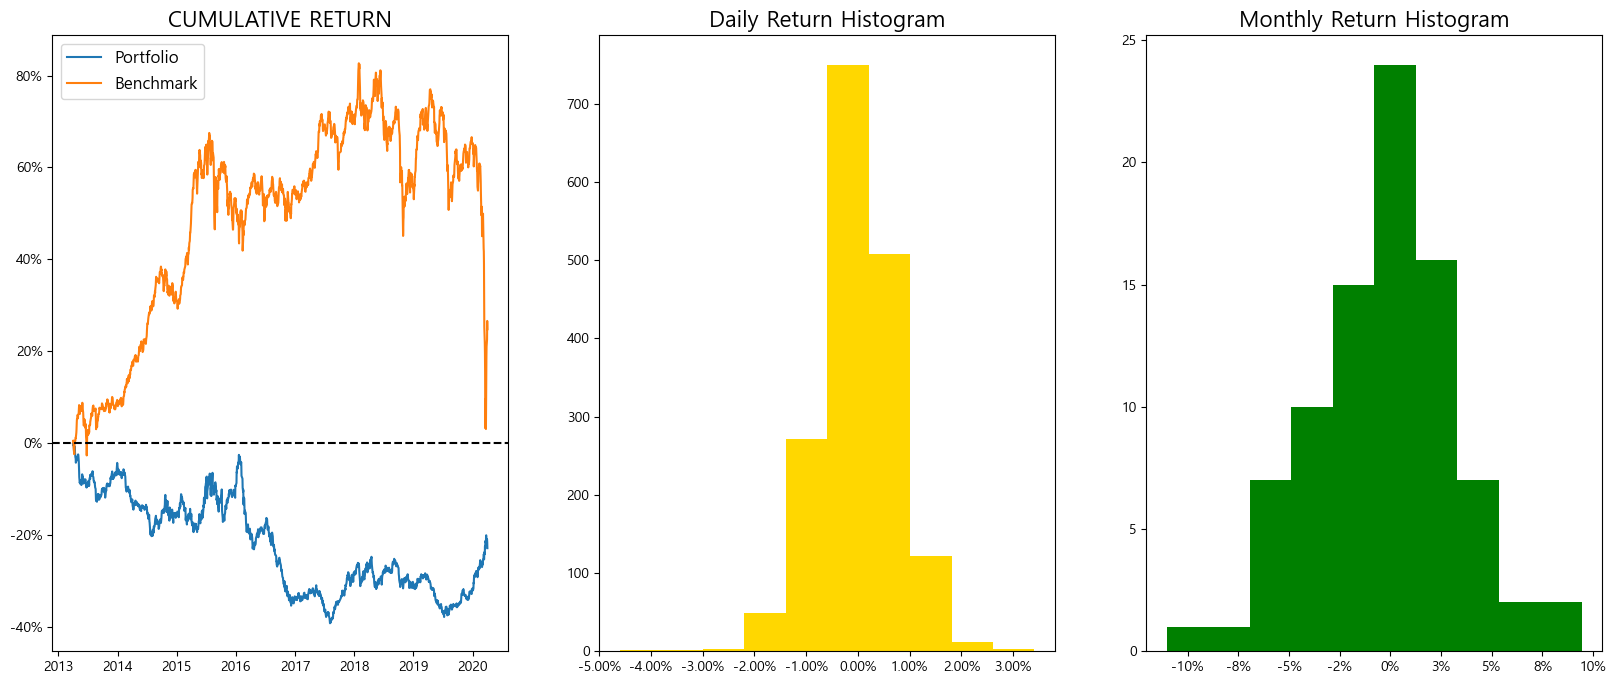

In [19]:
backtest.plot_return(daily_return, benchmark_return)

In [20]:
factor_test = backtest.test_factor(5, price_df, factor_df, money, rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.057039,0.027390,0.013423,0.022583,-0.005635
Annualized_std,0.119987,0.138543,0.135874,0.157510,0.164512
Annualized_sharpe,0.522912,0.264991,0.166463,0.221082,0.048324
MDD,-0.430834,-0.488372,-0.450294,-0.449644,-0.486391


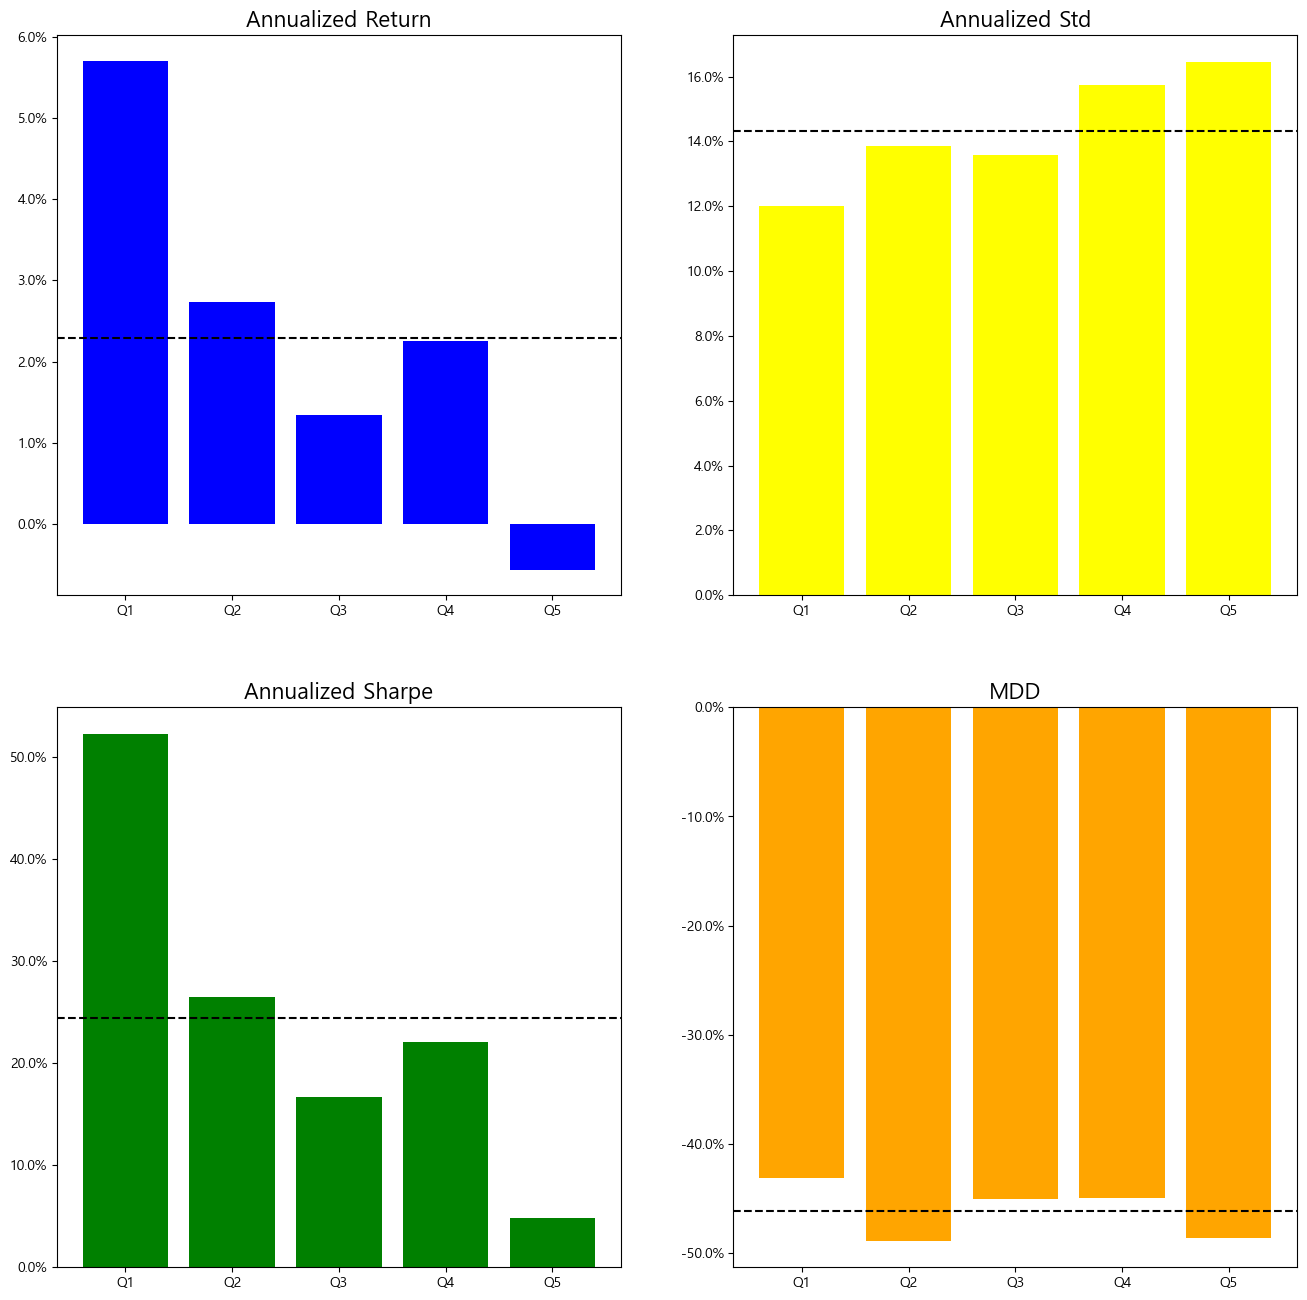

In [21]:
backtest.plot_factor_test_result(5, price_df, factor_df, money, rebalance_dates, commission,
                                interest, tax)

### 2-3 전략 수립 및 검증(2) - 가치주(Long Only)

##### 2-2의 결과를 통해 5분위를 제외한 모든 분위의 포트폴리오가 양의 수익률을 보이고 있는 것을 확인  
##### Long-Short보다는 Long-Only를 하는 것이 더 나은 수익률을 가져올 수도 있을 것으로 분석  
##### 그리고 PBR이 낮은 주식을 사는 것이 더 좋은 결과를 가져올 것으로 분석 (가치주 장세)  

##### **PBR 하위 40개 매수(PBR에 -1을 곱한 것을 팩터로 사용)**    
매수하는 자산의 비중은 1/40로 정함  
투자금액, 세금, 이자율, 수수료 등은 이전과 동일하다고 가정  
리밸런싱 주기는 20일로 설정  

##### **해당 기간의 누적수익률은 38.79%의 수익률을 보임(연간 4.92%)**    
##### **해당기간의 벤치마크 누적수익률은 24.75%(연간 3.29%)**      
Long Only포트폴리오가 더 낮은 변동성을 지님과 동시에 더 높은 수익률을 기록  

In [22]:
factor_df = factor_df.mul(-1)
signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [23]:
summary_stats = backtest.summary_stats(daily_return,benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,38.79%,24.75%
Annualized Return,4.92%,3.29%
Annualized Std,12.15%,13.37%
Annualized Sharpe,45.65%,30.98%
MDD,-45.80%,-43.61%
Var,-15.07%,-18.70%
C_Var,-20.14%,-24.28%
Shortfall Prob(min_return=0.00%),34.28%,40.27%


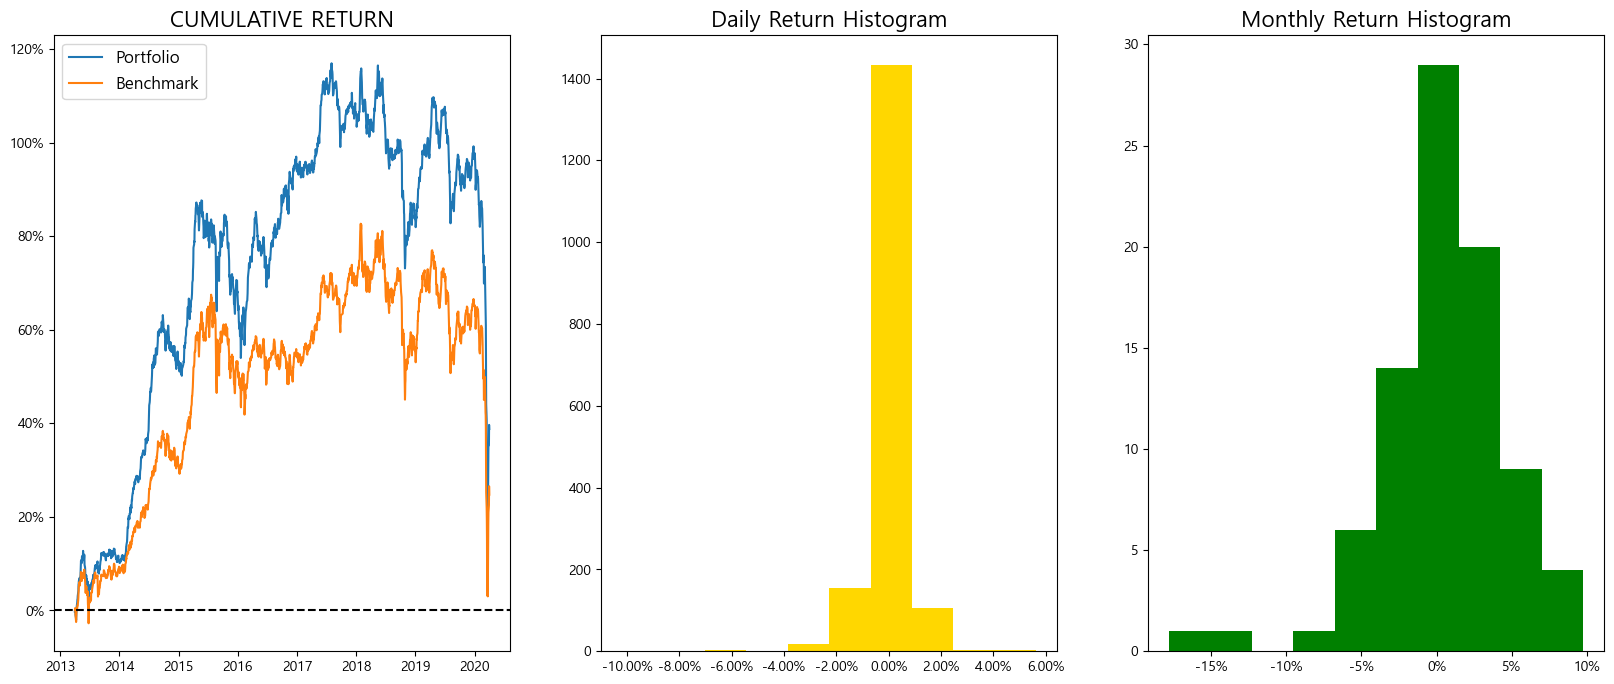

In [24]:
backtest.plot_return(daily_return, benchmark=benchmark_return)

In [25]:
factor_test = backtest.test_factor(5, price_df, factor_df, 1e9,rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.000267,0.021103,0.010262,0.029735,0.050295
Annualized_std,0.164043,0.155840,0.140105,0.136891,0.120469
Annualized_sharpe,0.084067,0.212382,0.143436,0.283176,0.468117
MDD,-0.475544,-0.436379,-0.477086,-0.471711,-0.442073


## 3. 전략 최적화 및 추가 분석

### 3-1 전략 최적화

##### 2-3의 전략을 수정해서 보다 더 좋은 성과를 내는 전략을 찾고자 함    
가치주 성장주를 판단하는 기준으로 PER도 사용할 수 있다. PER, PBR, PER순위+ PBR 순위를 통해 가치주 성장주 인지를 판단하고, 리밸런싱 주기도  20일, 40일,  60일, 80일, 100일 등으로 변경   
비중설정방식도 동일가중방식과 시가총액가중방식 등으로 변경   
샤프비율을 기준으로 순위를 매겨 봄   
전체적인 방식은 2-3과 동일

##### 다양한 전략들을 샤프비율을 기준으로 테스트해본 결과, 
##### pbr, 40일  단위로 리밸런싱, 동일가중방식이 가장 적합할 것으로 보여짐    

In [26]:
cap_df = kospi_cap[(kospi_cap.index >= start) & (kospi_cap.index <= end)]
pbr_df = kospi_pbr[(kospi_pbr.index >= start) & (kospi_pbr.index <= end)]
per_df = kospi_per[(kospi_per.index >= start) & (kospi_per.index <= end)]

In [27]:
set_signals = ['pbr', 'per', 'mix']
rebalance_periods = [20, 40, 60, 80, 100]
set_weights = ['equal', 'market_cap']
result_df = []
for set_signal in set_signals:
    for rebalance_period in rebalance_periods:
        for set_weight in set_weights:
            if set_signal == "pbr":
                factor_df = pbr_df.mul(-1)
                signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                                   long_min=-np.inf, short_max=np.inf, long_short=False)
            elif set_signal == 'per':
                factor_df = per_df.mul(-1)
                signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                                              long_min=-np.inf, short_max=np.inf, long_short=False)
            elif set_signal == 'mix':
                factor_df = pbr_df.rank(axis=1, ascending=False) + per_df.rank(axis=1, ascending=False)
                signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                                              long_min=-np.inf, short_max=np.inf, long_short=False)
            rebalance_dates = factor_df.index[::rebalance_period].tolist()
            if set_weight == 'equal':
                weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                                              n_min_positions=0, long_short=False)
            else:
                weights = backtest.generate_cap_weight_portfolio_from_signal(signal, n_positions=40,
                                                              n_min_positions=0, cap=cap_df, long_short=False)
            daily_return = backtest.backtest_from_weights(price_df, weights, money,
                                        rebalance_dates, commission, tax, interest)
            annualized_return = backtest.annualize_return(daily_return)
            annualized_sharpe = backtest.annualize_sharpe(daily_return)
            result_df.append([set_signal, rebalance_period, set_weight, annualized_return, annualized_sharpe])
opt_df = pd.DataFrame(result_df, columns=['set_signal', 'rebalance_period', 'set_weight',
                                          'annualized_return', 'annualized_sharpe'])
opt_df = opt_df.sort_values(by='annualized_sharpe', ascending=False)
opt_df = opt_df.reset_index(drop=True)
opt_df.head(10)

,set_signal,rebalance_period,set_weight,annualized_return,annualized_sharpe
0,pbr,40,equal,0.051552,0.475039
1,pbr,20,equal,0.049172,0.456542
2,pbr,60,equal,0.045735,0.427055
3,mix,20,equal,0.038448,0.368359
4,pbr,100,equal,0.036487,0.350926
5,mix,40,equal,0.033216,0.325135
6,pbr,80,equal,0.031817,0.319906
7,pbr,20,market_cap,0.046708,0.319849
8,per,20,equal,0.031201,0.304238
9,per,40,equal,0.026602,0.268073


##### pbr, 40일  단위로 리밸런싱, 동일가중방식

In [28]:
factor_df = pbr_df.mul(-1)
signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
rebalance_period=40
rebalance_dates = factor_df.index[::rebalance_period].tolist()
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                               n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [29]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,40.96%,24.75%
Annualized Return,5.16%,3.29%
Annualized Std,12.15%,13.37%
Annualized Sharpe,47.50%,30.98%
MDD,-45.83%,-43.61%
Var,-14.84%,-18.70%
C_Var,-19.91%,-24.28%
Shortfall Prob(min_return=0.00%),33.57%,40.27%


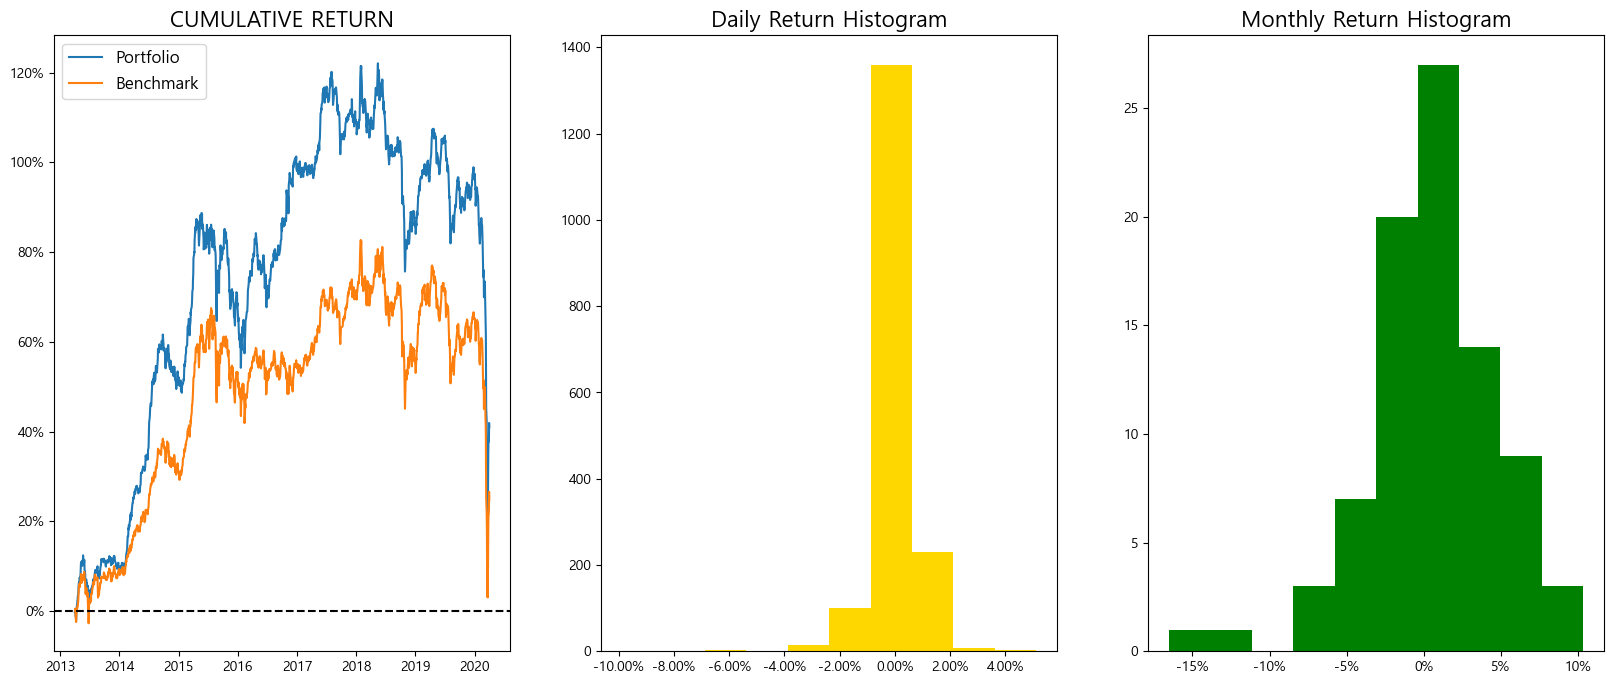

In [30]:
backtest.plot_return(daily_return, benchmark=benchmark_return)

### 3-2 추가분석

#####  Pyfolio, Quantstats 등의 Package를 활용해 보다 추가적인 분석을 진행하기로 함
전체적으로 좋은 성과를 보여주고 있지만 2020년 초에 급락  
해당 기간 동안 종목들이 전체적으로 하락하는 상황에서 포트폴리오에 있는 종목들이 더욱 급격히 급락한 것이 원인으로 분석  

In [31]:
import pyfolio as pf
import quantstats as qs
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe

In [32]:
daily_return = daily_return[daily_return.index >= benchmark_return.index[0]]

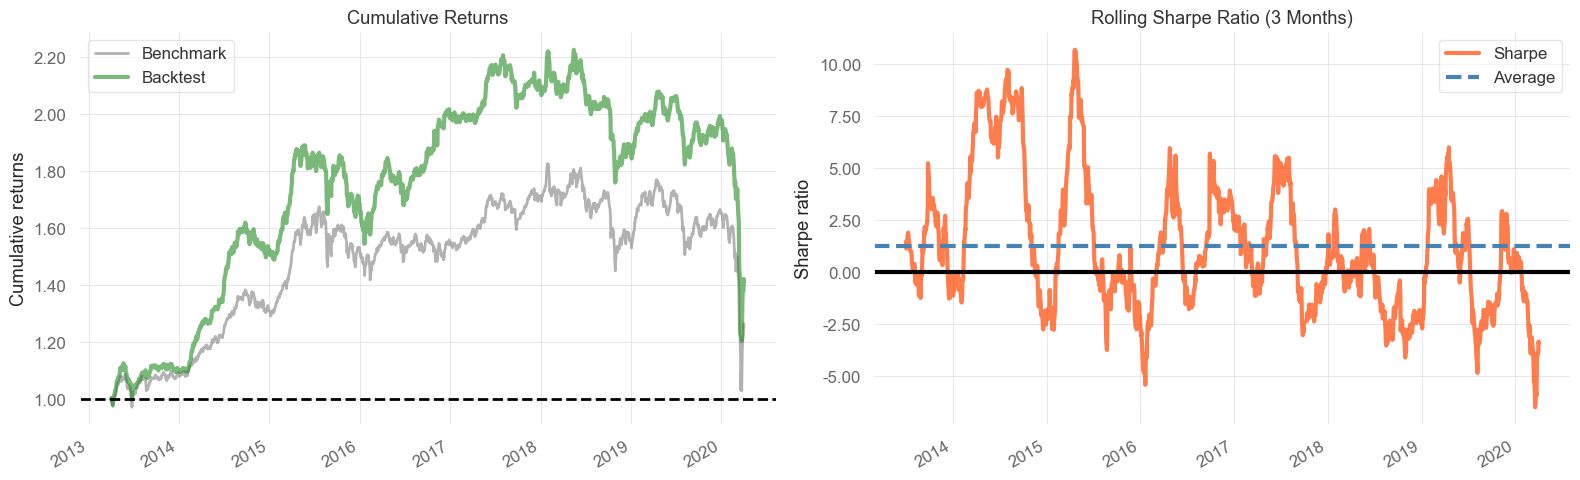

In [33]:
benchmark_return.name='Benchmark'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(daily_return,
                     factor_returns=benchmark_return,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

Start date,2013-04-02
End date,2020-04-01
Total months,81
,Backtest
Annual return,5.193%
Cumulative returns,41.274%
Annual volatility,12.157%
Sharpe ratio,0.48
Calmar ratio,0.11
Stability,0.62
Max drawdown,-45.832%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.83,2018-05-15,2020-03-23,NaT,NaN
1,18.28,2015-05-22,2016-01-20,2016-10-27,375
2,11.31,2013-05-22,2013-06-25,2014-02-12,191
3,8.34,2017-08-02,2017-09-25,2018-01-29,129
4,8.03,2014-09-26,2015-01-21,2015-02-25,109


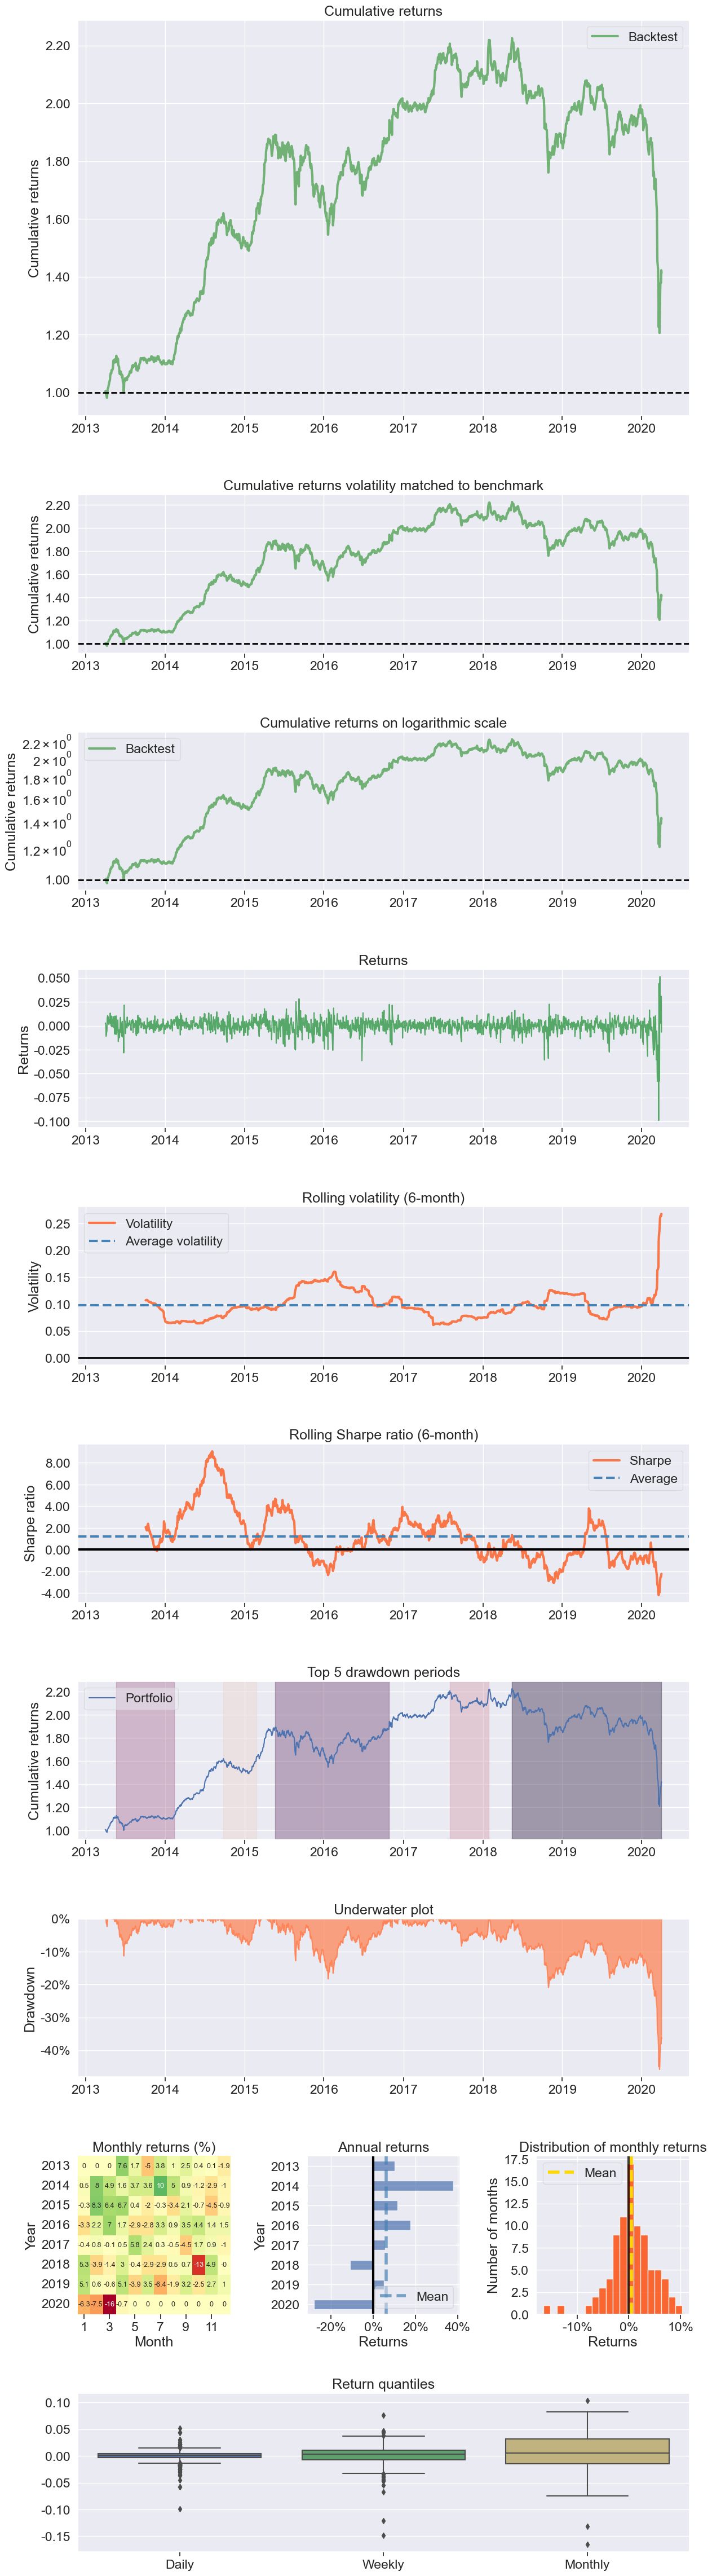

In [34]:
pf.create_returns_tear_sheet(daily_return)

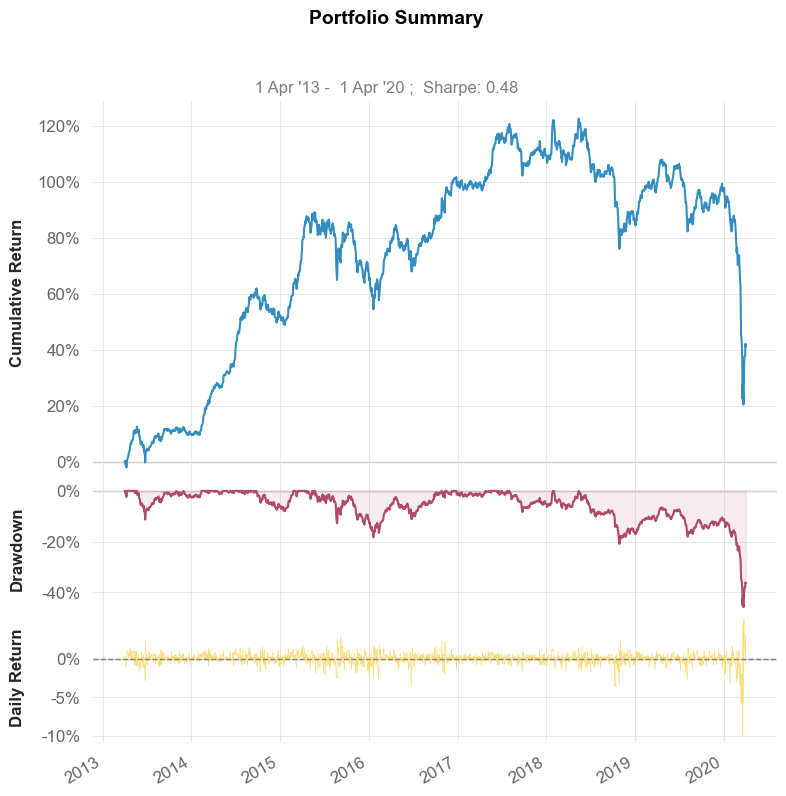

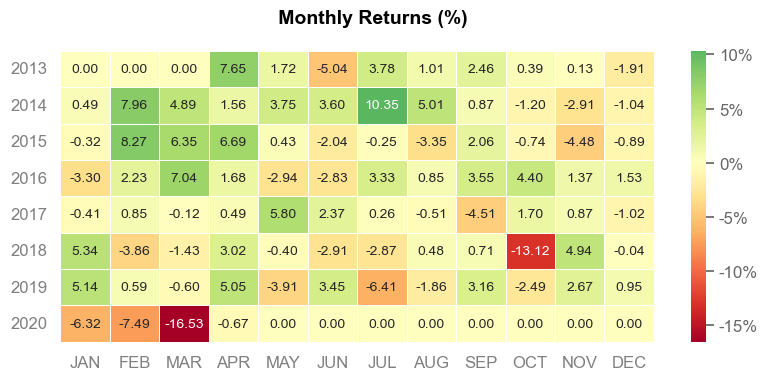

In [35]:
qs.reports.plots(daily_return, mode='basic')

In [36]:
qs.reports.metrics(daily_return, benchmark=benchmark_return, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2013-04-02  2013-04-02
End Period          2020-04-01  2020-04-01
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   41.27%      24.75%
CAGR﹪              5.06%       3.21%

Sharpe              0.48        0.31
Prob. Sharpe Ratio  88.67%      78.73%
Sortino             0.62        0.4
Sortino/√2          0.44        0.28
Omega               1.1         1.1

Max Drawdown        -45.83%     -43.61%
Longest DD Days     686         792

Gain/Pain Ratio     0.1         0.06
Gain/Pain (1M)      0.36        0.28

Payoff Ratio        0.82        0.77
Profit Factor       1.1         1.06
Common Sense Ratio  1.03        0.87
CPC Index           0.5         0.47
Tail Ratio          0.94        0.81
Outlier Win Ratio   3.42        3.3
Outlier Loss Ratio  4.76        4.1

MTD                 -0.67%      -1.43%
3M                  -28.15%     -24.57%

### 3-3 다른 기간에 대한 검증

##### 2022-04-01~2023-04-01까지의 기간에 대해 해당전략을 적용하고, 성과를 평가

##### **해당 기간의 누적수익률은 96.80%로 좋은 수익률을 보임(연간 25.85%)**    
##### **해당기간의 벤치마크누적수익률은 86.30%(연간 23.53%)**      
##### **벤치마크에 비해 낮은 변동성과 높은 수익률을 기록함. 이 전략은 유효하다고 할 수 있다.**

In [37]:
start, end = "2020-04-01", "2023-04-1"

price_df = kospi_price[(kospi_price.index >= start) & (kospi_price.index <= end)]
pbr_df = kospi_pbr[(kospi_pbr.index >= start) & (kospi_pbr.index <= end)]
factor_df = pbr_df.mul(-1)

In [38]:
benchmark_return = kospi_price.pct_change().dropna().mean(axis=1)
benchmark_return = benchmark_return[(benchmark_return.index >= start) & (benchmark_return.index <= end)]

In [39]:
rebalance_period = 40
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [40]:
factor_test = backtest.test_factor(5, price_df, factor_df, money, rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.187606,0.194829,0.296507,0.224653,0.260897
Annualized_std,0.202270,0.183700,0.176981,0.171937,0.162327
Annualized_sharpe,0.951540,1.061377,1.556547,1.265349,1.510073
MDD,-0.368774,-0.226080,-0.218415,-0.263806,-0.189520


In [41]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,96.80%,86.30%
Annualized Return,25.85%,23.53%
Annualized Std,16.14%,16.65%
Annualized Sharpe,150.58%,135.34%
MDD,-18.73%,-22.73%
Var,-0.70%,-3.85%
C_Var,-7.45%,-10.81%
Shortfall Prob(min_return=0.00%),5.47%,7.88%


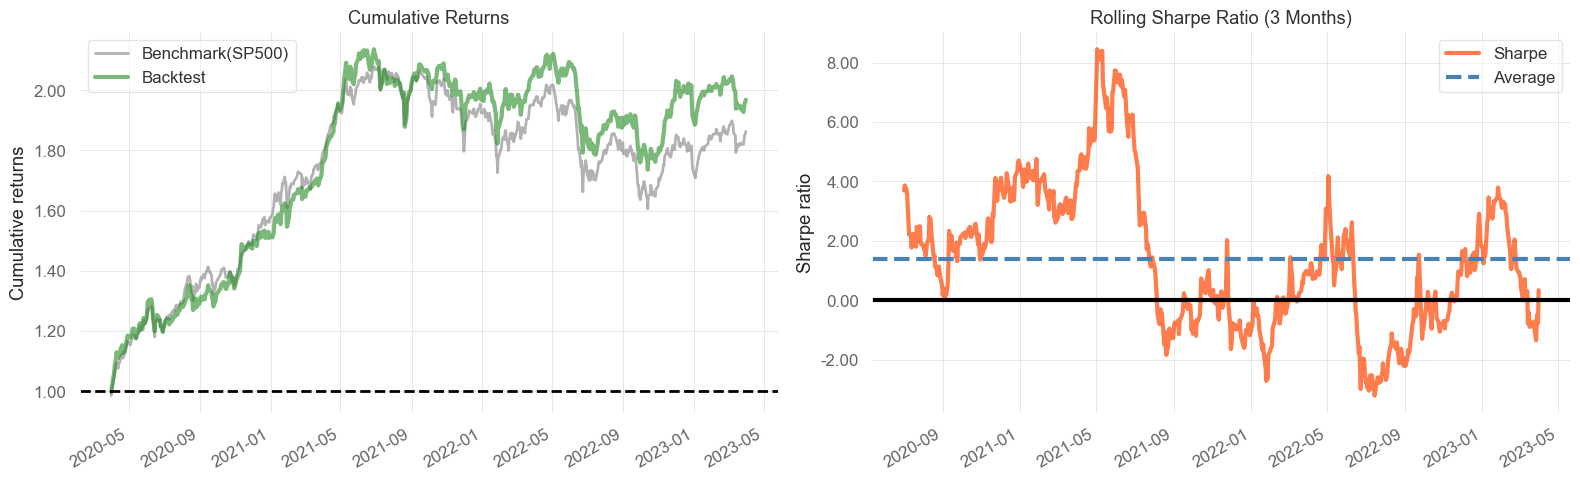

In [42]:
benchmark_return.name='Benchmark(SP500)'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(daily_return,
                     factor_returns=benchmark_return,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

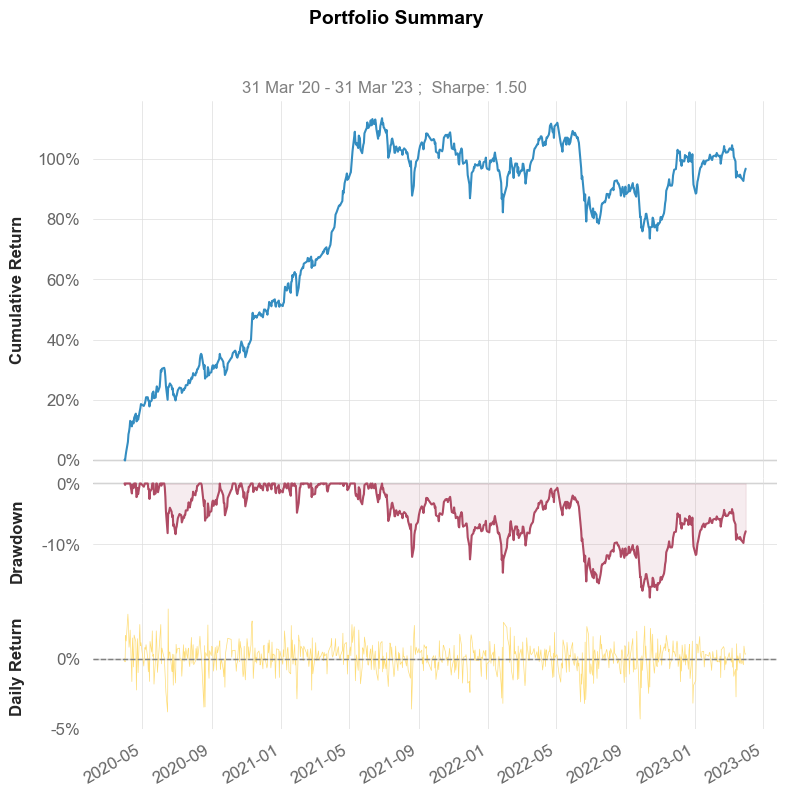

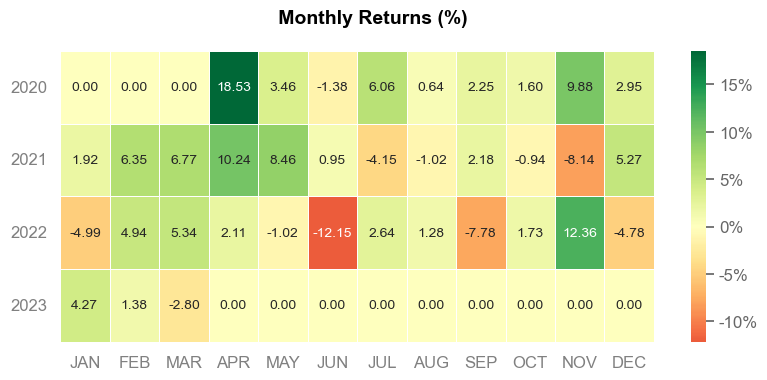

In [43]:
qs.reports.plots(daily_return, mode='basic')

In [44]:
qs.reports.metrics(daily_return, benchmark=benchmark_return, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-04-01  2020-04-01
End Period          2023-03-31  2023-03-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   96.8%       86.3%
CAGR﹪              25.34%      23.07%

Sharpe              1.51        1.35
Prob. Sharpe Ratio  99.4%       98.81%
Sortino             2.12        1.88
Sortino/√2          1.5         1.33
Omega               1.29        1.29

Max Drawdown        -18.73%     -22.73%
Longest DD Days     640         640

Gain/Pain Ratio     0.29        0.25
Gain/Pain (1M)      1.45        1.2

Payoff Ratio        0.85        0.85
Profit Factor       1.29        1.25
Common Sense Ratio  1.26        1.09
CPC Index           0.65        0.62
Tail Ratio          0.98        0.87
Outlier Win Ratio   3.28        3.19
Outlier Loss Ratio  3.74        3.62

MTD                 -2.8%       0.04%
3M                  2.76%       7.02%